In [1]:
from scipy.optimize import minimize, fmin
from pathlib import Path

import nicpolpy as nic
import numpy as np
import pandas as pd
from nicpolpy import ysphotutilpy4nicpolpy as ypu
from nicpolpy import ysfitsutilpy4nicpolpy as yfu
from astropy.stats import sigma_clip, sigma_clipped_stats
from astropy.time import Time
from scipy.interpolate import interp1d
from IPython.core.interactiveshell import InteractiveShell
from matplotlib import pyplot as plt
from matplotlib import rcParams
from photutils.aperture import EllipticalAperture
import itertools

%config InlineBackend.figure_format = 'retina'
InteractiveShell.ast_node_interactivity = 'last_expr'

# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'latin modern math', 'font.size':12, 'mathtext.fontset':'stix', 
    'axes.formatter.use_mathtext': True, 'axes.formatter.limits': (-4, 4),
    'axes.grid': True, 'grid.color': 'gray', 'grid.linewidth': 0.5, 
    'xtick.top': True, 'ytick.right': True, 
    'xtick.direction': 'inout', 'ytick.direction': 'inout',
    'xtick.minor.size': 2.0, 'ytick.minor.size': 2.0,  # default 2.0
    'xtick.major.size': 4.0, 'ytick.major.size': 4.0,  # default 3.5
    'xtick.minor.visible': True, 'ytick.minor.visible': True
})

def linexp_ha0(x, k=10, h=0.1, a0=20):
    e0 = np.exp(-a0/k)

    # numer = a0*(np.exp(-a*x) + a*np.exp(-a*a0)*x - 1)
    numer = (1 - e0)*x - (1 - np.exp(-x/k))*a0
    denom = 1 - (1 + a0/k)*e0
    return h*(numer/denom)

def log_likelihood(theta, x, y, yerr):
    model = linexp_ha0(x, *theta)
    sigsq = yerr**2
    return -0.5*np.sum((y - model)**2 / sigsq + np.log(2*np.pi*sigsq))
    #      Shouldn't we need 2 π here?                 ^^^^^^^^

def nll(*args):
    return -log_likelihood(*args)

def get_mle(x, y, yerr, p0):
    return minimize(nll, p0, args=(x, y, yerr), bounds=((1.e-6, None), (1.e-6, None), (5, 40)))


def _gesd(x, alpha=0.01, outliers=0.1, outliers_min=1):
    if (nx := x.compressed().size) >= 4:
        outliers = int(outliers) if outliers >= 1 else int(nx*outliers)
        mask = nic.outliers_gesd(x.filled(100), alpha=alpha, hypo=True,
                                outliers=max(outliers_min, outliers))
        if mask.dtype == "bool":
            return mask
        else:
            return False
    return False


def _wvg(x, dx):
    x = np.ma.array(x)
    dx = np.ma.array(dx)
    return (np.ma.average(x.compressed(), weights=1/dx.compressed()**2),
            1/np.sqrt(np.ma.sum(1/dx.compressed()**2)))


def qupa(qv, uv, dqv, duv, pa_obs, alpha, outliers, outliers_min=1):
    # def _mask_minmax(x):
    #     if x.compressed().size > 10:
    #         x.mask = (x.min() == x) | (x == x.max())  # mask min/max
    # def _sigc(x, sigma=5, stdfunc="mad_std"):
    #     if x.compressed().size > 5:
    #         _, _md, _sd = sigma_clipped_stats(x.compressed(), sigma=3, stdfunc=stdfunc)
    #         x.mask |= (x < _md - sigma*_sd) | (x > _md + sigma*_sd)

    qv = np.ma.array(qv, mask=np.isnan(qv))
    uv = np.ma.array(uv, mask=np.isnan(uv))
    dqv = np.ma.array(dqv, mask=np.isnan(dqv))
    duv = np.ma.array(duv, mask=np.isnan(duv))

    qv, uv, dqv, duv = ypu.correct_pa(qv, uv, dqv, duv, pa_obs=pa_obs, pa_ccw=False,
                                      in_pct=True, out_pct=True, in_deg=True)
    qv.mask = _gesd(qv, alpha=alpha, outliers=outliers, outliers_min=outliers_min)
    uv.mask = _gesd(uv, alpha=alpha, outliers=outliers, outliers_min=outliers_min)
    fullmask = qv.mask | uv.mask
    # print(np.sqrt((qv - q)**2 + (uv - u)**2))
    # _sigc(qv)
    # _sigc(uv)
    qv.mask = fullmask
    uv.mask = fullmask
    dqv.mask = fullmask
    duv.mask = fullmask
    # _mask_minmax(np.ma.array(qv, mask=np.isnan(qv)))
    # _mask_minmax(np.ma.array(uv, mask=np.isnan(uv)))
    # snrq = np.ma.array(snrq, mask=fullmask)
    # snru = np.ma.array(snru, mask=fullmask)

    # qv = _sigc(qv, sigma=sigma, stdfunc=stdfunc)
    # uv = _sigc(uv, sigma=sigma, stdfunc=stdfunc)
    q_w, dq_w = _wvg(qv, dqv)
    u_w, du_w = _wvg(uv, duv)

    dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)
    fullmask |= _gesd(dist, alpha=alpha, outliers=outliers, outliers_min=outliers_min)
    # print(dist, np.percentile(dist, 80))
    # print((dist > np.percentile(dist, 80)))
    # fullmask |= (dist > np.percentile(dist, 80))
    # print(fullmask)
    qv.mask = fullmask
    uv.mask = fullmask
    dqv.mask = fullmask
    duv.mask = fullmask
    q_w, dq_w = _wvg(qv, dqv)
    u_w, du_w = _wvg(uv, duv)
    return (q_w, u_w, dq_w, du_w, qv, uv)


def rtheta2xy(r, theta):
    theta = 180 - 2*np.array(theta)
    return r*np.cos(np.deg2rad(theta)), r*np.sin(np.deg2rad(theta))


basenames = [
    "SP_20190417", "SP_20190422", "UP_20180314", "UP_20180509",
    "Ceres_20200621", "Ceres_20201002", "Ceres_20201018", "Ceres_20210909", "Ceres_20211107",
    "Vesta_20191022", "Vesta_20191108", "Vesta_20191121", "Vesta_20191218", "Vesta_20200110", "Vesta_20200213"
]
rapmodes = ["min", "max", "minoe", "maxoe", 25, 30, 35, 40]
set2rm = dict(
    # Vesta_20191108=[1, 2, 3, 16, 24, 25, 26, 30, 31, 37, 44, 45,
    #                 52, 61, 62, 63, 64, 86, 87, 88, 89, 90, 91, 92, 93, 94,
    #                 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107,
    #                 108, 109, ],
)


respaths = list(Path("results/").glob("*.csv"))
respaths.sort()
ALPHA = 0.05
SNRMIN = 20
DQDUMAX = 0.5
SNRFACTOR = 5
THETA_0 = np.array([10, 0.1, 20])

# Saving ephemerides

In [2]:
for respath in respaths:
    if (not respath.name.startswith("Ceres")) and (not respath.name.startswith("Vesta")):
        continue
    dfp = pd.read_csv(respath)
    ephpath = Path(f"eph/{'_'.join(respath.stem.split('_')[:-1])}_eph.csv")
    if not ephpath.exists():
        midjd = Time(dfp["midut"].unique().tolist(), format="isot").jd
        eph = ypu.HorizonsDiscreteEpochsQuery(
            respath.name.split("_")[0],
            location=nic.NHAO_LOCATION,
            epochs=midjd,
        ).query(depoch=50).to_pandas()
        eph.sort_values("datetime_jd", inplace=True)
        # eph.insert(loc=0, column="midjd_targ", value=midjd - eph["lighttime"]/86400)
        eph.to_csv(ephpath, index=False)
    eph = pd.read_csv(ephpath)
    dfp.insert(loc=3, column="midjd", value=Time(dfp["midut"].tolist(), format="isot").jd)

    for c in ["AZ", "airmass", "r", "delta", "lighttime", "alpha", "sunTargetPA"]:
        dfp[c] = interp1d(eph["datetime_jd"], eph[c], fill_value="extrapolate")(dfp["midjd"])

    dfp.insert(loc=2, column="midjd_targ", value=dfp["midjd"] - dfp["lighttime"]/(24*60))

# q-u Plot for each (object, rapmode) combination

In [3]:
d4d = dict(
    objname=[], filt=[], rapmode=[], midjd_targ=[], airmass=[], alpha=[], r=[], delta=[],
    nused=[], P=[], dP=[], thetaP=[], dthetaP=[], Pr=[], dPr=[], thetar=[], dthetar=[],
)

for respath in respaths:
    # if not respath.name.startswith("Vesta_20191108"):
    #     continue
    if (not respath.name.startswith("Ceres")) and (not respath.name.startswith("Vesta")):
        continue
    ephpath = Path(f"eph/{'_'.join(respath.stem.split('_')[:-1])}_eph.csv")
    rapmode = respath.stem.split("_")[-1]
    dfp = pd.read_csv(respath)
    eph = pd.read_csv(ephpath)
    dfp.insert(loc=3, column="midjd", value=Time(dfp["midut"].tolist(), format="isot").jd)

    for c in ["AZ", "airmass", "r", "delta", "lighttime", "alpha", "sunTargetPA"]:
        dfp[c] = interp1d(eph["datetime_jd"], eph[c], fill_value="extrapolate")(dfp["midjd"])

    dfp.insert(loc=2, column="midjd_targ", value=dfp["midjd"] - dfp["lighttime"]/(24*60))

    if (rmid := set2rm.get("_".join(respath.stem.split("_")[:2]))) is not None:
        dfp = dfp.loc[~dfp["setid"].isin(rmid)].copy()

    for objname in dfp.object.unique():
        if objname in ["sky", "FS12"]:
            continue
        fig, axs = plt.subplots(1, 1, figsize=(8, 8), sharex=False, sharey=False)
        axp = axs

        for i_filt, (filt, col) in enumerate(zip("JHK", "bgr")):
            # remove if
            # (1) minimum SNR < SNRMIN (faint object) or
            # (2) delta-SNR > minimum SNR*factor (abrupt sky change) or
            # (3) nominal error in q or u > DQDUMAX
            mask = ((dfp["filt"] == filt) & (dfp["object"] == objname)
                    & (dfp["snr_q"] > SNRMIN) & (dfp["snr_u"] > SNRMIN)
                    & (dfp["dsnr_q"] < (dfp["snr_q"]/SNRFACTOR))
                    & (dfp["dsnr_u"] < (dfp["snr_u"]/SNRFACTOR))
                    & (dfp["dq"] < DQDUMAX) & (dfp["du"] < DQDUMAX))

            _dfp = dfp[mask]
            # print(objname, filt, len(_dfp))
            if len(_dfp) == 0:
                continue
            q, u, dqw, duw, qv, uv = qupa(_dfp["q"].to_numpy(), _dfp["u"].to_numpy(),
                                        _dfp["dq"].to_numpy(), _dfp["du"].to_numpy(),
                                        _dfp["pa"].to_numpy(), alpha=ALPHA, 
                                        outliers=0.3, outliers_min=1)
            nused = qv.compressed().size
            sq = max(dqw, np.ma.std(qv, ddof=1) / np.sqrt(nused)) if nused > 1 else np.nan
            su = max(duw, np.ma.std(uv, ddof=1) / np.sqrt(nused)) if nused > 1 else np.nan
            # (objname, filt, qv)
            p0 = np.sqrt(q**2+u**2)/(nic.PEFF[filt]/100)
            dp0 = np.sqrt((q*sq)**2 + (u*su)**2)/p0
            th0 = 0.5*np.rad2deg(np.arctan2(u, q))
            dth0 = 0.5*np.rad2deg(dp0/p0)
            nuse = qv.size - (qv.mask | uv.mask).sum()
            stpa = np.mean(_dfp["sunTargetPA"])
            pr, thr, dpr, dthr = ypu.calc_pol_r(p0, th0, dp0, dth0, suntargetpa=stpa,
                                                in_pct=True, in_deg=True, out_deg=True, out_pct=True)
            # print(f"{objname} ({filt}): {p0:.2f}±{dp0:.2f} ({nuse}/{qv.size}, snr={p0/dp0:.0f})")

            kw = dict(color=col, marker=".")
            axp.errorbar(qv.compressed(), uv.compressed(),
                         xerr=_dfp["dq"][~qv.mask], yerr=_dfp["du"][~uv.mask],
                         capsize=0, elinewidth=0.5, ls="", alpha=0.4, **kw)
            if not np.isnan(q) and not np.isnan(u):
                # quap = EllipticalAperture([q, u], a=dq, b=du, theta=0)
                # quap.plot(axp, color=col)
                if sq > 0 and su > 0:
                    quap = EllipticalAperture([q, u], a=sq, b=su, theta=0)
                    quap.plot(axp, color=col)
            axp.scatter(
                np.nan, np.nan, **kw,
                label=(f"* {filt}\nP  = {p0:.2f}±{dp0:.2f}%\n"
                       + f"Pr ={pr:+.2f}±{dpr:.2f}%\nθr = {thr:.1f}±{dthr:.1f}°\n"
                       + "q  ={:+.2f}±{:.2f}%\nu  ={:+.2f}±{:.2f}%\n".format(q, sq, u, su)
                       + r"used=$\,\frac{{{}}}{{{}}}$, ".format(nuse, _dfp["q"].size)
                       + r"$\frac{{P}}{{ΔP}}=${:.1f}".format(p0/dp0)
                       )
            )
            d4d["objname"].append(objname)
            d4d["filt"].append(filt)
            d4d["rapmode"].append(rapmode)
            for k in ["midjd_targ", "airmass", "alpha", "r", "delta"]:
                d4d[k].append(np.mean(_dfp[k][~qv.mask]))
            d4d["nused"].append(nused)
            d4d["P"].append(p0)
            d4d["dP"].append(dp0)
            d4d["thetaP"].append(th0)
            d4d["dthetaP"].append(dth0)
            d4d["Pr"].append(pr)
            d4d["dPr"].append(dpr)
            d4d["thetar"].append(thr)
            d4d["dthetar"].append(dthr)

            for _q, _u, _id in zip(qv.compressed(), uv.compressed(),
                                   _dfp["setid"].to_numpy()[~qv.mask]):
                # txt = "({:.1f}, {:.1f}) = {:.1f}\n({:.1f}, {:.1f}) = {:.1f}".format(
                #     row["dxq"], row["dyq"], row["drq"], row["dxu"], row["dyu"], row["dru"])
                # txt = row["setid"]
                axp.text(_q, _u, _id, color=col, fontsize=8)

        delta = np.max((np.ptp(axp.get_xlim())/2, np.ptp(axp.get_ylim())/2))

        axp.set(
            title="{} ({}): α = {:.1f}°".format(objname, respath.stem.split("_", 1)[1], dfp["alpha"].mean()),
            xlabel="q_PAcorr [%]",
            ylabel="u_PAcorr [%]",
            xlim=(np.mean(axp.get_xlim()) - delta, np.mean(axp.get_xlim()) + delta),
            ylim=(np.mean(axp.get_ylim()) - delta, np.mean(axp.get_ylim()) + delta),
        )
        xlim, ylim = axp.get_xlim(), axp.get_ylim()
        x_spn = 100*np.cos(np.deg2rad(-2*stpa))  # scattering plane normal vector
        y_spn = 100*np.sin(np.deg2rad(-2*stpa))  # scattering plane normal vector
        axp.plot([0, x_spn], [0, y_spn], "k-", lw=2, alpha=0.5, label=r"$θ_r = 0° ~(P_r > 0)$")
        axp.plot([-x_spn, 0], [-y_spn, 0], "k:", lw=2, alpha=0.5, label=r"$θ_r = 90° ~(P_r < 0)$")
        axp.set(xlim=xlim, ylim=ylim)
        axp.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10, prop={'family': 'monospace'})
        axp.set_aspect("equal")
        axp.axhline(0, lw=2, color="k")
        axp.axvline(0, lw=2, color="k")
        # xy_spi = rtheta2xy(delta, (90 + stpa + 45))  # scattering plane in-plane vector
        # axp.plot([-xy_spi[0], xy_spi[0]], [-xy_spi[1], xy_spi[1]], "k:", lw=2, alpha=0.5)
        # axp.plot([0, delta*np.cos(2*np.deg2rad(stpa))], [0, delta*np.sin(2*np.deg2rad(stpa))],
        #          color="k", lw=2, alpha=0.5)
        # axp.plot([0, delta*np.cos(2*np.deg2rad(90+stpa))], [0, delta*np.sin(2*np.deg2rad(90+stpa))],
        #          color="k", lw=2, ls="--", alpha=0.5)

        plt.tight_layout()
        fig.align_ylabels(axs)
        fig.align_xlabels(axs)
        plt.savefig(f"results/figs/{respath.stem}_{objname}_{np.median(eph['alpha']):.1f}.png", dpi=300)
        print(f"{respath.stem}_{objname}_{np.median(eph['alpha']):.1f}")
        plt.close("all")

df_fin = pd.DataFrame(d4d)
df_fin.to_csv("results/df_fin.csv", index=False)


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)


Ceres_20200621_25_Ceres_18.9
Ceres_20200621_30_Ceres_18.9
Ceres_20200621_35_Ceres_18.9
Ceres_20200621_40_Ceres_18.9


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)


Ceres_20200621_max_Ceres_18.9
Ceres_20200621_maxoe_Ceres_18.9


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)


Ceres_20200621_min_Ceres_18.9


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)


Ceres_20200621_minoe_Ceres_18.9
Ceres_20201002_25_Ceres_13.1
Ceres_20201002_30_Ceres_13.1


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)


Ceres_20201002_35_Ceres_13.1
Ceres_20201002_40_Ceres_13.1
Ceres_20201002_max_Ceres_13.1
Ceres_20201002_maxoe_Ceres_13.1
Ceres_20201002_min_Ceres_13.1
Ceres_20201002_minoe_Ceres_13.1
Ceres_20201018_25_Ceres_16.5
Ceres_20201018_30_Ceres_16.5
Ceres_20201018_35_Ceres_16.5
Ceres_20201018_40_Ceres_16.5
Ceres_20201018_max_Ceres_16.5
Ceres_20201018_maxoe_Ceres_16.5
Ceres_20201018_min_Ceres_16.5
Ceres_20201018_minoe_Ceres_16.5
Ceres_20210909_25_Ceres_20.8
Ceres_20210909_30_Ceres_20.8
Ceres_20210909_35_Ceres_20.8
Ceres_20210909_40_Ceres_20.8
Ceres_20210909_max_Ceres_20.8


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)


Ceres_20210909_maxoe_Ceres_20.8
Ceres_20210909_min_Ceres_20.8
Ceres_20210909_minoe_Ceres_20.8
Ceres_20211107_25_Ceres_8.6
Ceres_20211107_30_Ceres_8.6
Ceres_20211107_35_Ceres_8.6
Ceres_20211107_40_Ceres_8.6
Ceres_20211107_max_Ceres_8.6
Ceres_20211107_maxoe_Ceres_8.6
Ceres_20211107_min_Ceres_8.6
Ceres_20211107_minoe_Ceres_8.6
Vesta_20191022_25_Vesta_10.4
Vesta_20191022_30_Vesta_10.4
Vesta_20191022_35_Vesta_10.4
Vesta_20191022_40_Vesta_10.4
Vesta_20191022_max_Vesta_10.4
Vesta_20191022_maxoe_Vesta_10.4
Vesta_20191022_min_Vesta_10.4
Vesta_20191022_minoe_Vesta_10.4


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)


Vesta_20191108_25_Vesta_4.1


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)


Vesta_20191108_30_Vesta_4.1


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)


Vesta_20191108_35_Vesta_4.1


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)


Vesta_20191108_40_Vesta_4.1


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)


Vesta_20191108_max_Vesta_4.1


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)


Vesta_20191108_maxoe_Vesta_4.1


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)


Vesta_20191108_min_Vesta_4.1


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)


Vesta_20191108_minoe_Vesta_4.1


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)


Vesta_20191121_25_Vesta_5.7


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)


Vesta_20191121_30_Vesta_5.7


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)


Vesta_20191121_35_Vesta_5.7


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)


Vesta_20191121_40_Vesta_5.7


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)


Vesta_20191121_max_Vesta_5.7


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)


Vesta_20191121_maxoe_Vesta_5.7


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)


Vesta_20191121_min_Vesta_5.7


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)


Vesta_20191121_minoe_Vesta_5.7
Vesta_20191218_25_Vesta_15.6
Vesta_20191218_30_Vesta_15.6
Vesta_20191218_35_Vesta_15.6
Vesta_20191218_40_Vesta_15.6
Vesta_20191218_max_Vesta_15.6
Vesta_20191218_maxoe_Vesta_15.6
Vesta_20191218_min_Vesta_15.6
Vesta_20191218_minoe_Vesta_15.6
Vesta_20200110_25_Vesta_20.7
Vesta_20200110_30_Vesta_20.7
Vesta_20200110_35_Vesta_20.7


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)


Vesta_20200110_40_Vesta_20.7
Vesta_20200110_max_Vesta_20.7
Vesta_20200110_maxoe_Vesta_20.7
Vesta_20200110_min_Vesta_20.7
Vesta_20200110_minoe_Vesta_20.7
Vesta_20200213_25_Vesta_22.5
Vesta_20200213_30_Vesta_22.5


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)


Vesta_20200213_35_Vesta_22.5


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)


Vesta_20200213_40_Vesta_22.5
Vesta_20200213_max_Vesta_22.5
Vesta_20200213_maxoe_Vesta_22.5
Vesta_20200213_min_Vesta_22.5
Vesta_20200213_minoe_Vesta_22.5


# Rotational variation

In [4]:
prots_h = dict(Vesta=5.342, Ceres=9.074170)

for respath in respaths:
    if (not respath.name.startswith("Ceres")) and (not respath.name.startswith("Vesta")):
        continue
    ephpath = Path(f"eph/{'_'.join(respath.stem.split('_')[:-1])}_eph.csv")
    dfp = pd.read_csv(respath)
    eph = pd.read_csv(ephpath)
    dfp.insert(loc=3, column="midjd", value=Time(dfp["midut"].tolist(), format="isot").jd)

    for c in ["AZ", "airmass", "r", "delta", "lighttime", "alpha", "sunTargetPA"]:
        dfp[c] = interp1d(eph["datetime_jd"], eph[c], fill_value="extrapolate")(dfp["midjd"])

    dfp.insert(loc=2, column="midjd_targ", value=dfp["midjd"] - dfp["lighttime"]/(24*60))

    if (rmid := set2rm.get("_".join(respath.stem.split("_")[:2]))) is not None:
        dfp = dfp.loc[~dfp["setid"].isin(rmid)].copy()

    for objname in dfp.object.unique():
        if objname in ["sky", "FS12"]:
            continue
        fig, axs = plt.subplots(1, 1, figsize=(8, 5), sharex=False, sharey=False)
        axt = axs
        p_nominal, dp_nominal = [], []
        tmin = dfp["midjd_targ"].min()

        for i_filt, (filt, col) in enumerate(zip("JHK", "bgr")):
            # remove if
            # (1) minimum SNR < SNRMIN (faint object) or
            # (2) delta-SNR > minimum SNR*factor (abrupt sky change) or
            # (3) nominal error in q or u > 0.5
            mask = ((dfp["filt"] == filt) & (dfp["object"] == objname)
                    & (dfp["snr_q"] > SNRMIN) & (dfp["snr_u"] > SNRMIN)
                    & (dfp["dsnr_q"] < (dfp["snr_q"]/SNRFACTOR))
                    & (dfp["dsnr_u"] < (dfp["snr_u"]/SNRFACTOR))
                    & (dfp["dq"] < DQDUMAX) & (dfp["du"] < DQDUMAX))

            _dfp = dfp[mask]
            if len(_dfp) == 0:
                p_nominal.append(np.nan)
                dp_nominal.append(np.nan)
                continue
            q, u, dq, du, qv, uv = qupa(_dfp["q"].to_numpy(), _dfp["u"].to_numpy(),
                                        _dfp["dq"].to_numpy(), _dfp["du"].to_numpy(),
                                        _dfp["pa"].to_numpy(), alpha=ALPHA, 
                                        outliers=0.3, outliers_min=1)
            sqrt_n = np.sqrt(qv.compressed().size)
            sq = np.ma.std(qv, ddof=1) / sqrt_n if qv.compressed().size > 1 else np.nan
            su = np.ma.std(uv, ddof=1) / sqrt_n if qv.compressed().size > 1 else np.nan
            # (objname, filt, qv)
            p0 = np.sqrt(q**2+u**2)
            dp0 = np.sqrt((q*sq)**2 + (u*su)**2)/p0
            th0 = 0.5*np.rad2deg(np.arctan2(u, q))
            nuse = qv.size - (qv.mask | uv.mask).sum()
            stpa = np.mean(_dfp["sunTargetPA"])

            times = (Time(_dfp["midjd_targ"], format="jd").jd - tmin)*24
            # t_off = i_filt*(np.ptp(times)/times.size/5)  # minor offset for better visibility
            p_off = i_filt*1
            axt.plot(times[~qv.mask], _dfp["pol"][~qv.mask] + p_off, color=col, ls="-", lw=0.5)
            axt.errorbar(times, _dfp["pol"] + p_off, yerr=_dfp["dpol"],
                         capsize=0, elinewidth=0.5, lw=0.5, marker=".", color=col, ls="")
            axt.scatter(times[qv.mask], _dfp["pol"][qv.mask] + p_off,
                        marker="x", color="k", s=50)

            for _t, _p, _id in zip(times[::5], _dfp["pol"].to_numpy()[::5],
                                   _dfp["setid"].to_numpy()[::5]):
                axt.text(_t, _p + p_off, _id, color=col, fontsize=8)

            p_nominal.append(p0+p_off)
            dp_nominal.append(dp0)
        delta = np.max((np.ptp(axp.get_xlim())/2, np.ptp(axp.get_ylim())/2))
        tmax = axt.get_xlim()[1]
        for _p0, _dp0, col in zip(p_nominal, dp_nominal, "bgr"):
            if np.isnan(_p0):
                continue
            axt.errorbar([tmax], [_p0], yerr=[_dp0], color=col, ls="", marker="*", lw=0.5, capsize=3, elinewidth=1)
        axt.set(
            title="{} ({}): α = {:.1f}°\nProt = {:.3f}h".format(
                objname, respath.stem.split("_", 1)[1], dfp["alpha"].mean(), prots_h[objname]),
            xlabel="time [h]",
            ylabel="P [%]",
            xlim=(0, 1.05*tmax)
        )

        # plt.tight_layout()
        fig.align_ylabels(axs)
        fig.align_xlabels(axs)
        plt.savefig(f"results/figs-time/{respath.stem}_{objname}_{np.median(eph['alpha']):.1f}_pol_time.png", dpi=300)
        plt.close("all")



/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)
/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)
/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)
/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)
/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: RuntimeWarning: invalid value encountered in sqrt
  dist = np.sqrt((qv - q_w)**2 + (uv - u_w)**2)
/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_84129/1527341494.py:111: Runtim

# Comparison for rapmodes

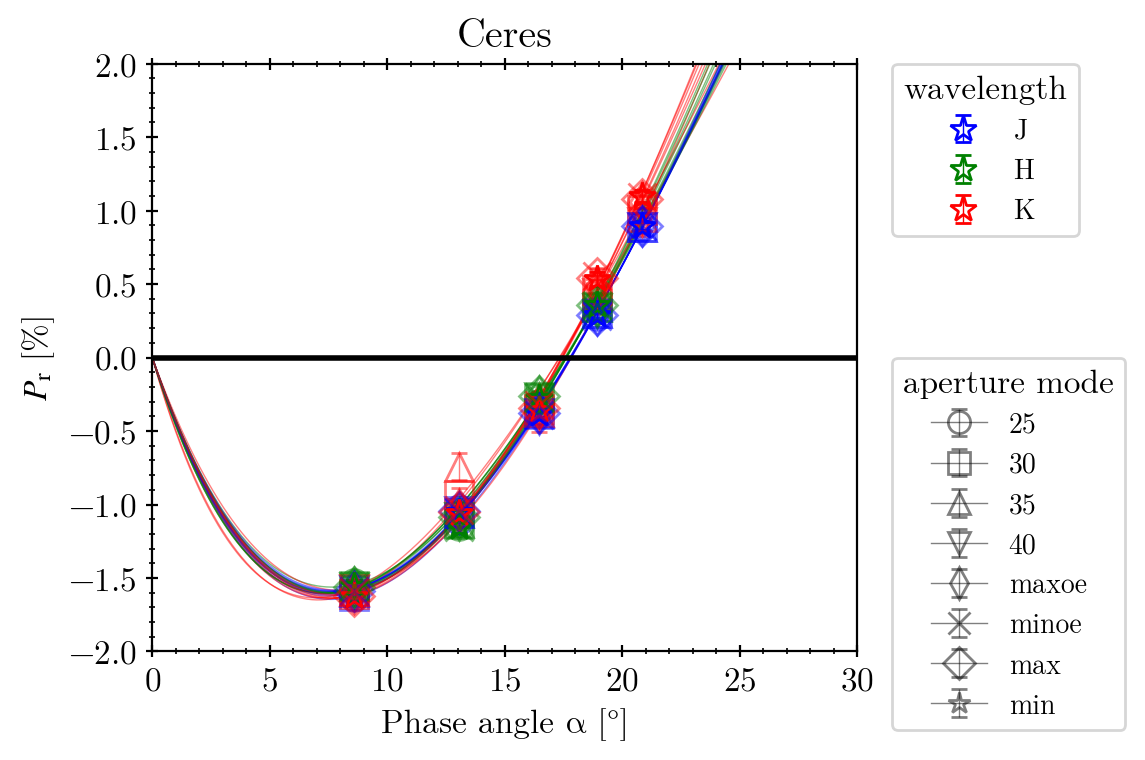

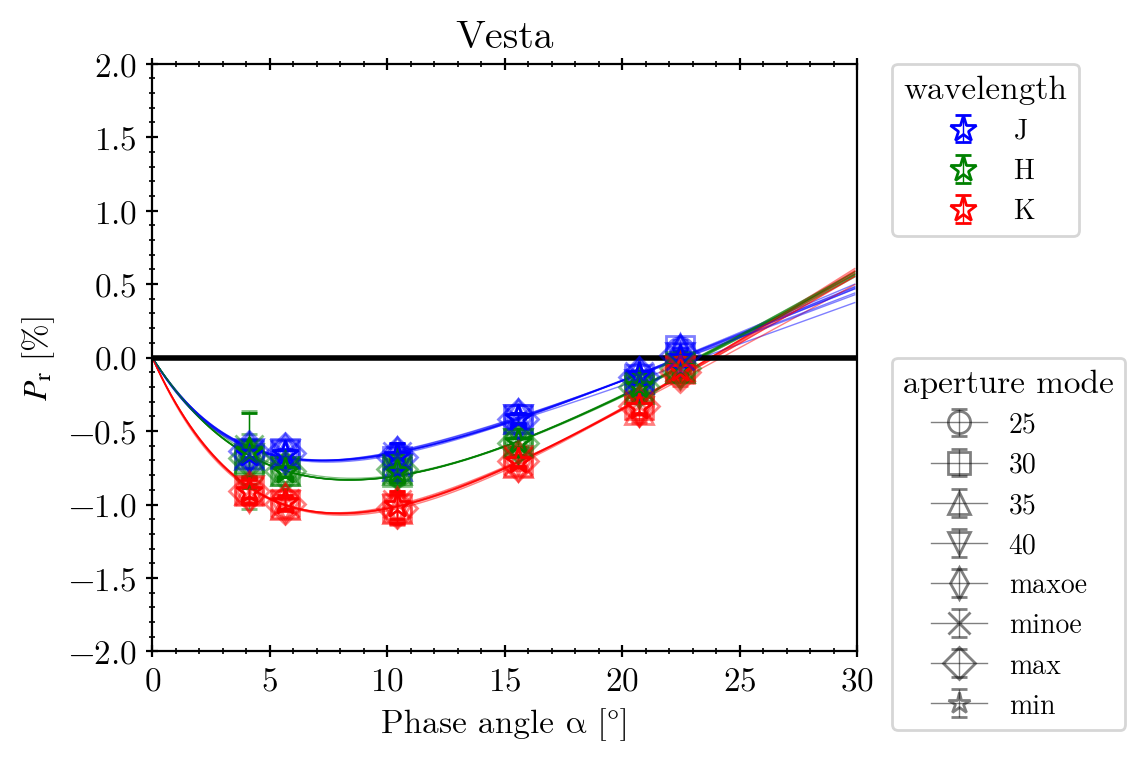

In [5]:
plt.close("all")

markers = {"25": "o", "30": "s", "35": "^", "40": "v",
           "maxoe": "d", "minoe": "x", "max": "D", "min": "*", }
xx = np.arange(0, 30, 0.1)
df_cv = pd.read_csv("results/df_fin.csv")
errbfmt = dict(lw=0.5, capsize=3, elinewidth=0.5, mfc="none")

fits = dict(obj=[], filt=[], rapmode=[], h=[], a0=[], am=[], pm=[])
for obj in df_cv["objname"].unique():
    fig, axs = plt.subplots(1, 1, figsize=(6, 4), sharex=False, sharey=False, gridspec_kw=None)
    for rapmode, (filt, c, offset) in itertools.product(df_cv["rapmode"].unique(), zip("JHK", "bgr", [0, 0, 0])):
        _df = df_cv.loc[(df_cv["objname"] == obj) & (df_cv["filt"] == filt) & (df_cv["rapmode"] == rapmode)]
        _df = _df.sort_values("alpha")
        x, y = _df["alpha"].to_numpy(), _df["Pr"].to_numpy()
        dy = np.nanmax((_df["dP"], _df["dPr"]), axis=0)
        popt = get_mle(x, y, dy, p0=THETA_0).x
        axs.errorbar(x, y+offset, yerr=dy,
                     label=f"{filt}" if rapmode == "min" else "",
                     color=c, marker=markers[rapmode],
                     alpha=1 if rapmode == "min" else 0.5, ms=10, ls="", **errbfmt)
        axs.plot(xx, linexp_ha0(xx, *popt), color=c, lw=0.5, alpha=0.5)
        amin = fmin(linexp_ha0, x0=5, args=tuple(popt), disp=False)[0]
        pmin = linexp_ha0(amin, *popt)
        fits["obj"].append(obj)
        fits["filt"].append(filt)
        fits["rapmode"].append(rapmode)
        fits["h"].append(popt[1])
        fits["a0"].append(popt[2])
        fits["am"].append(amin)
        fits["pm"].append(pmin)

    ax2 = axs.twinx()
    ax2.axis("off")
    for rapmode, mk in markers.items():
        ax2.errorbar(np.nan, np.nan, yerr=np.nan, color="k",
                     label=rapmode, marker=mk, ms=8, alpha=0.5, **errbfmt)
    axs.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10, title="wavelength")
    ax2.legend(bbox_to_anchor=(1.05, 0.5), loc=2, borderaxespad=0., fontsize=10, title="aperture mode")
    axs.set(
        xlabel="Phase angle α [°]",
        ylabel=r"$P_\mathrm{r}$ [%]",
        xlim=(0, 30),
        # ylim=(-2, 2.5),
        ylim=(-2, 2),
        title=f"{obj}",
    )
    axs.axhline(0, color="k", lw=2)
    axs.grid(False)

    plt.tight_layout()
    plt.savefig("results/figs/{}_pol_alpha.png".format(obj), dpi=300)
    plt.savefig("results/figs/{}_pol_alpha.pdf".format(obj), dpi=300)
    # plt.show()
fits = pd.DataFrame(fits)